# Imports

In [1]:
import tensorflow as tf
# from tensorflow.python.framework.ops import disable_eager_execution 
# disable_eager_execution()
# from tensorflow.python.framework.ops import enable_eager_execution
# enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Import common tensorflow layers and activations
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.layers import Lambda, Multiply, Add, Rescaling
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import Input

from tabnet import TabNet
from tabnet import TabNetClassifier

# Data Defn

In [12]:
BATCH_SIZE = 16384

# Load telematics data
telematics = pd.read_csv("./telematics_syn-032021.csv")
outputs = ['NB_Claim', 'AMT_Claim']
response = 'Risky_driver'
telematics[response] = ((telematics['NB_Claim'] > 0) & (telematics['AMT_Claim'] > 1000)).astype(float)
telematics.drop([x for x in outputs if x != response], axis=1, inplace=True)

# Split data into train and test
data_train, data_test = train_test_split(telematics, test_size=0.3, random_state=42)
data_val, data_test = train_test_split(data_test, test_size=0.33, random_state=42)

# Mean target encode categorical variables
aggregate_fn = np.mean
for col in ['Marital', 'Insured.sex', 'Car.use', 'Region', 'Territory']:
    encoding = data_train.groupby(col)[response].aggregate(aggregate_fn)
    data_train[col] = data_train[col].map(encoding)
    data_val[col] = data_val[col].map(encoding)
    data_test[col] = data_test[col].map(encoding)

# Split into X and y
X_train = data_train.drop(response, axis=1, errors='ignore')
y_train = data_train[response]
X_val = data_val.drop(response, axis=1, errors='ignore')
y_val = data_val[response]
X_test = data_test.drop(response, axis=1, errors='ignore')
y_test = data_test[response]

# Scale input data - save scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Make tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train[..., np.newaxis]))
train_dataset = train_dataset.shuffle(buffer_size=4048).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val[..., np.newaxis]))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test[..., np.newaxis]))
test_dataset = test_dataset.batch(BATCH_SIZE)

/tmp/ipykernel_8664/1702190313.py:37: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train[..., np.newaxis]))
/tmp/ipykernel_8664/1702190313.py:39: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val[..., np.newaxis]))
/tmp/ipykernel_8664/1702190313.py:41: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test[..., np.newaxis]))


# Model creation and training

In [50]:
import tensorflow as tf
import tabnet
from importlib import reload
reload(tabnet)

from tabnet import TabNet

online_implementation = TabNet(
    feature_columns=None,
    output_dim=64,
    feature_dim=128,
    num_features=X_train.shape[1],
    num_decision_steps=5,
    relaxation_factor=1.5,
    sparsity_coefficient=0.0001,
    virtual_batch_size=512,
    norm_type="batch",
    batch_momentum=0.7,
)

online_implementation = Sequential([
    online_implementation,
    Dense(1, activation="sigmoid")
])


online_implementation.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.02,
            decay_steps=500,
            decay_rate=0.95
        ),
    ),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.AUC(from_logits=False, name="auc"),
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
        tf.keras.metrics.Precision(name="precision", thresholds=0.5),
        tf.keras.metrics.Recall(name="recall", thresholds=0.5)
    ]
)


[TabNet]: 64 features will be used for decision steps.


In [51]:
sample = next(iter(train_dataset))
x = np.arange(len(sample[0].numpy()))
online_implementation(sample[0])

<tf.Tensor: shape=(16384, 1), dtype=float32, numpy=
array([[0.50022095],
       [0.4995658 ],
       [0.50116795],
       ...,
       [0.50100034],
       [0.4984247 ],
       [0.4950452 ]], dtype=float32)>

In [27]:
# local_implementation = TabNet(dim_features=X_train.shape[1], dim_attention=16, dim_output=1, output_activation=None)

# local_implementation.compile( 
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
#     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=[
#         tf.keras.metrics.AUC(from_logits=True, name="auc"),
#         # # tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
#         # tf.keras.metrics.Precision(name="precision", thresholds=0),
#         # tf.keras.metrics.Recall(name="recall", thresholds=0)
#         ]
# )
# local_implementation.build(X_train[:1].shape)

In [28]:
online_implementation.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tab_net_6 (TabNet)           (16384, 64)               399136    
_________________________________________________________________
dense_1 (Dense)              (16384, 1)                65        
Total params: 399,201
Trainable params: 392,657
Non-trainable params: 6,544
_________________________________________________________________


In [52]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, monitor="val_auc")
# lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)
history = online_implementation.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/1000
4/4 [==============================] - 15s 2s/step - loss: 0.2661 - auc: 0.5382 - binary_accuracy: 0.9064 - precision: 0.0284 - recall: 0.0738 - val_loss: 0.1603 - val_auc: 0.5840 - val_binary_accuracy: 0.9731 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
4/4 [==============================] - 8s 2s/step - loss: 0.1314 - auc: 0.6816 - binary_accuracy: 0.9727 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1344 - val_auc: 0.7197 - val_binary_accuracy: 0.9730 - val_precision: 0.2500 - val_recall: 0.0023
Epoch 3/1000
4/4 [==============================] - 7s 2s/step - loss: 0.1230 - auc: 0.7124 - binary_accuracy: 0.9725 - precision: 0.1429 - recall: 0.0011 - val_loss: 0.1299 - val_auc: 0.7392 - val_binary_accuracy: 0.9730 - val_precision: 0.3333 - val_recall: 0.0023
Epoch 4/1000
4/4 [==============================] - 7s 2s/step - loss: 0.1210 - auc: 0.7287 - binary_accuracy: 0.9728 - precision: 0.3333 - recall: 5.6085e-04 - val_loss: 0.1262 - va

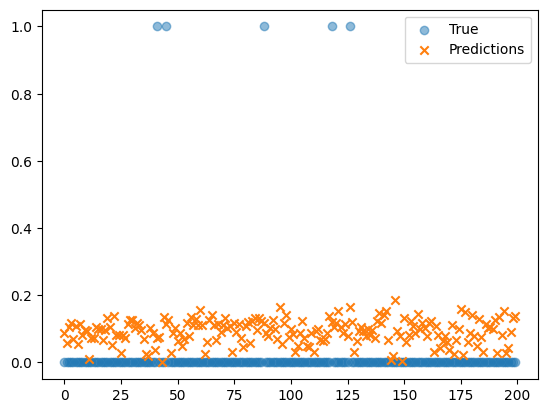

In [53]:
sample = next(iter(train_dataset))
x = np.arange(len(sample[0].numpy()))
y_pred = online_implementation(sample[0]).numpy().flatten()
y_true = sample[1].numpy().flatten()
sample_plot = 200
plt.scatter(x[:sample_plot], y_true[:sample_plot], label="True", alpha=0.5)
plt.scatter(x[:sample_plot], y_pred[:sample_plot], label="Predictions", marker="x")
plt.legend()
tf.keras.metrics.Recall(name="recall", thresholds=0)

NameError: name 'local_implementation' is not defined

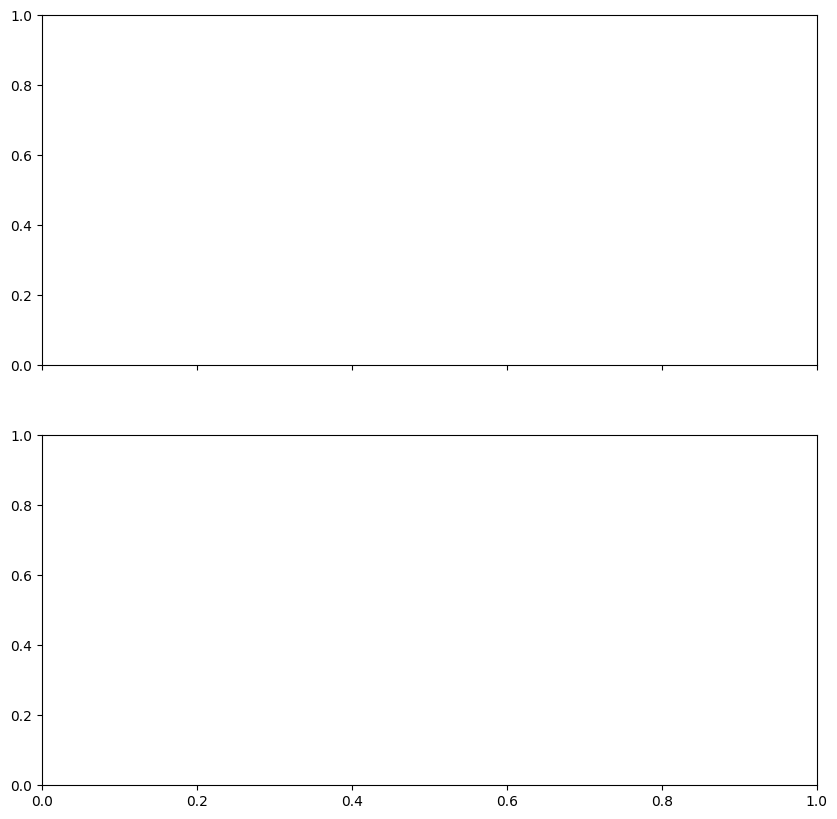

In [54]:
# Plot history loss and RMSE for training and validation set; train solid line, validation dashed line
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

hist = local_implementation.history.history

top_ax.plot(hist['loss'], label='train_loss', c='b')
top_ax.plot(hist['val_loss'], label='val_loss', linestyle='--', c='b')
second_ax = top_ax.twinx()
# Plot precision and recall on second axis in orange and red respectively
second_ax.plot(hist['precision'], label='train_precision', c='orange')
second_ax.plot(hist['val_precision'], label='val_precision', linestyle='--', c='orange')
second_ax.plot(hist['recall'], label='train_recall', c='r')
second_ax.plot(hist['val_recall'], label='val_recall', linestyle='--', c='r')
top_ax.set_ylabel('loss')
second_ax.set_ylabel('Precision/Recall')
# Merge top ax legend entries
handles, labels = top_ax.get_legend_handles_labels()
handles2, labels2 = second_ax.get_legend_handles_labels()
top_ax.legend(handles + handles2, labels + labels2)


bottom_ax.plot(hist['lr'], label='lr', c='g')
bottom_ax.set_xlabel('Epoch')
bottom_ax.set_ylabel('Learning rate')

# New plot with auc and accuracy
fig, ax = plt.subplots()
ax.plot(hist['auc'], label='train_auc', c='orange')
ax.plot(hist['val_auc'], label='val_auc', linestyle='--', c='orange')
twinax = ax.twinx()
twinax.plot(hist['binary_accuracy'], label='train_accuracy', c='r')
twinax.plot(hist['val_binary_accuracy'], label='val_accuracy', linestyle='--', c='r')
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
twinax.set_ylabel('Accuracy')
# Merge legend entries
handles, labels = ax.get_legend_handles_labels()
twinhandles, twinlabels = twinax.get_legend_handles_labels()
ax.legend(handles + twinhandles, labels + twinlabels)




In [56]:
# Evaluate model on test set
online_implementation.evaluate(test_dataset)

InvalidArgumentError:  Input to reshape is a tensor with 2534400 values, but the requested shape requires a multiple of 131072
	 [[node sequential_2/tab_net_7/transform_block_112/transformblock_bn_f1/Reshape (defined at home/alexander/projects/deep_learning_vs_gbdt/venv/lib/python3.9/site-packages/tabnet/tabnet.py:34) ]] [Op:__inference_test_function_91403]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_2/tab_net_7/transform_block_112/transformblock_bn_f1/Reshape:
 sequential_2/tab_net_7/transform_block_112/transformblock_dense_f1/MatMul (defined at home/alexander/projects/deep_learning_vs_gbdt/venv/lib/python3.9/site-packages/tabnet/tabnet.py:33)

Function call stack:
test_function
